<a href="https://colab.research.google.com/github/mstavens/Cancer/blob/Brain_Tumors_Detection/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the required libraries
import kagglehub
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install optuna
import optuna
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [ ]:
# Import the dataset files from kaggle

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:07<00:00, 20.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
# List all the files of the dataset
print("Files in the dataset directory:")
print(os.listdir(path))

Files in the dataset directory:
['Testing', 'Training']


In [ ]:
# Collect the train files and labels to create the train dataframe

train_dir = os.path.join(path, "Training")

filepaths = []
labels = []
folds = os.listdir(train_dir)

for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(fold)

train_df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  5712 non-null   object
 1   labels     5712 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB


In [ ]:
# Collect the test files and labels to create the train dataframe

test_dir = os.path.join(path, "Testing")

filepaths = []
labels = []
folds = os.listdir(test_dir)

for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(fold)

test_df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1311 non-null   object
 1   labels     1311 non-null   object
dtypes: object(2)
memory usage: 20.6+ KB


We can already see that in both dataframes, there are no missing values.

In [ ]:
# Detect duplicate entries
duplicates_train = train_df.duplicated()
duplicates_test = test_df.duplicated()
nb_duplicate_train = duplicates_train.sum()
nb_duplicate_test = duplicates_test.sum()
print(f"Number of duplicate entries in train dataframe is : {nb_duplicate_train}. \nNumber of duplicate entries in test dataframe is : {nb_duplicate_test}. ")

Number of duplicate entries in train dataframe is : 0. 
Number of duplicate entries in test dataframe is : 0. 


In [ ]:
# Split the test dataset into validation and test datasets
validation_df , test_df = train_test_split(test_df, test_size=0.5 , random_state=42)

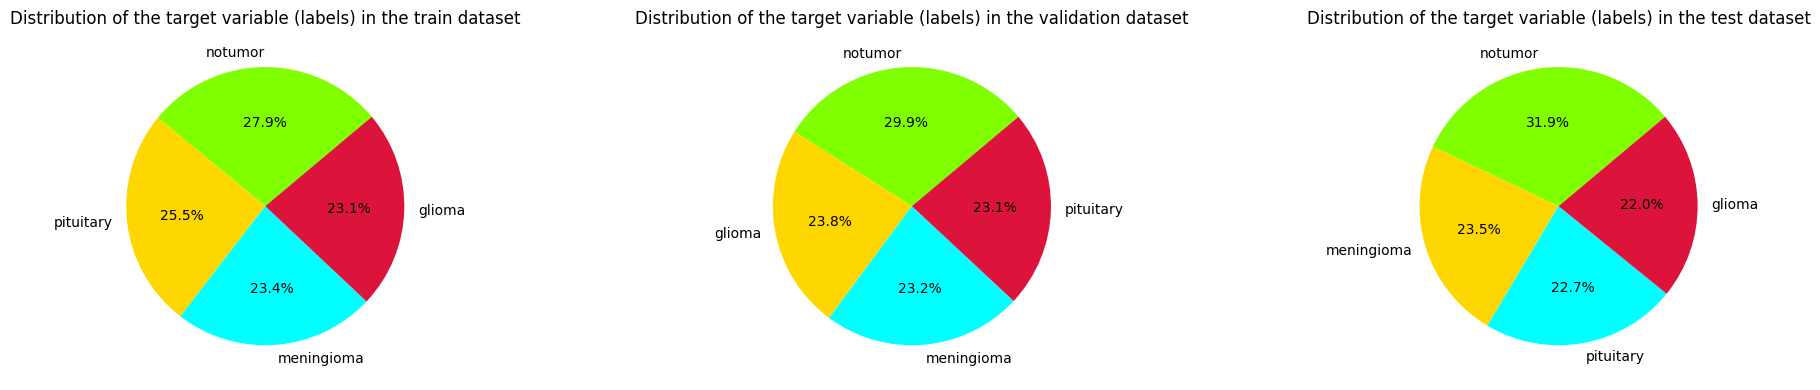

In [ ]:
#Check the distribution of the target variable in all the datasets (train, validation and test)

target_distribution_train = train_df['labels'].value_counts()
target_distribution_validation = validation_df['labels'].value_counts()
target_distribution_test = test_df['labels'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

axes[0].pie(
    target_distribution_train,
    labels=target_distribution_train.index,
    autopct='%1.1f%%',
    startangle=40,
    colors=['chartreuse','gold','aqua','crimson']
)
axes[0].set_title('Distribution of the target variable (labels) in the train dataset')

axes[1].pie(
    target_distribution_validation,
    labels=target_distribution_validation.index,
    autopct='%1.1f%%',
    startangle=40,
    colors=['chartreuse','gold','aqua','crimson']
)
axes[1].set_title('Distribution of the target variable (labels) in the validation dataset')

axes[2].pie(
    target_distribution_test,
    labels=target_distribution_test.index,
    autopct='%1.1f%%',
    startangle=40,
    colors=['chartreuse','gold','aqua','crimson']
)
axes[2].set_title('Distribution of the target variable (labels) in the test dataset')

plt.tight_layout()
plt.show()

In [ ]:

gen=ImageDataGenerator()
train_gen= gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size=(256,256) ,color_mode='rgb', class_mode='categorical', batch_size= 32)

valid_gen= gen.flow_from_dataframe(validation_df, x_col='filepaths', y_col='labels',target_size=(256,256) ,color_mode='rgb', class_mode='categorical', batch_size= 32)

test_gen= gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size=(256,256) ,color_mode='rgb', class_mode='categorical', batch_size= 32)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
#Print the classes and their indexes
print(test_gen.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Utiliser les meilleurs hyperparamètres trouvés par Optuna
#best_params = study.best_params

# Créer et compiler le modèle final avec les meilleurs paramètres
final_model2 = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='linear', input_shape=(256, 256, 3)),  # Adapter la taille de l'image
    layers.MaxPooling2D(),
    layers.Conv2D(256, (3, 3), activation='linear'),  # Plus de filtres dans la 2ème couche
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='linear'),
    layers.Dense(4, activation='softmax')
])

# Compiler le modèle avec les meilleurs hyperparamètres
final_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Entraîner le modèle final
final_model2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,  # Vous pouvez ajuster le nombre d'époques
    batch_size=32,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 288ms/step - accuracy: 0.5959 - loss: 151.0622 - val_accuracy: 0.8473 - val_loss: 6.9577
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 214ms/step - accuracy: 0.9113 - loss: 3.9182 - val_accuracy: 0.8824 - val_loss: 5.5785
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 218ms/step - accuracy: 0.9541 - loss: 1.9947 - val_accuracy: 0.8870 - val_loss: 4.9193
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.9742 - loss: 1.3327 - val_accuracy: 0.9069 - val_loss: 4.2166
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.9838 - loss: 0.7163 - val_accuracy: 0.8901 - val_loss: 4.8885
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.9939 - loss: 0.5301 - val_accuracy: 0.9160 - val_loss: 4.4231
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.9948 - loss: 0.3570 - val_accuracy: 0.9160 - val_loss: 3.4202
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.9941 - loss: 0.4243 - v

In [ ]:
final_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 984064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      62,980,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,837,518 (724.17 MB)

 Trainable params: 63,279,172 (241.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 126,558,346 (482.78 MB)

In [ ]:
# Save the model
final_model2.save('/content/drive/MyDrive/Colab_Notebooks/final_model_brain_tumor_detection.keras')


In [ ]:
from tensorflow.keras.models import load_model

final_model2 = load_model('/content/drive/MyDrive/Colab_Notebooks/final_model_brain_tumor_detection.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluate the model

In [ ]:
#Evaluate on Test dataset
test_loss, test_accuracy = final_model2.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2f}, \nTest Loss: {test_loss:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9324 - loss: 2.7345
Test Accuracy: 0.93, 
Test Loss: 2.95


In [ ]:
#Prediction
predictions = final_model2.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

#Generate Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
[[29 36 39 40]
 [31 35 57 31]
 [48 53 66 42]
 [25 40 49 35]]


In [ ]:
# Générer un rapport de classification
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      glioma       0.22      0.20      0.21       144
  meningioma       0.21      0.23      0.22       154
     notumor       0.31      0.32      0.31       209
   pituitary       0.24      0.23      0.24       149

    accuracy                           0.25       656
   macro avg       0.25      0.24      0.24       656
weighted avg       0.25      0.25      0.25       656



In [ ]:
#Accuracy
accuracy = np.sum(true_classes == predicted_classes) / len(true_classes)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.25


In [ ]:
# Nombre de classes
n_classes = conf_matrix.shape[0]

# Calcul de la spécificité pour chaque classe
for i in range(n_classes):
    TP = conf_matrix[i, i]  # Vrais positifs pour la classe i
    FP = np.sum(conf_matrix[:, i]) - TP  # Faux positifs pour la classe i
    FN = np.sum(conf_matrix[i, :]) - TP  # Faux négatifs pour la classe i
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # Vrais négatifs pour la classe i

    specificity = TN / (TN + FP)  # Spécificité
    print(f"Specificity for class {i}: {specificity:.2f}")

Specificity for class 0: 0.80
Specificity for class 1: 0.74
Specificity for class 2: 0.68
Specificity for class 3: 0.78


In [ ]:
# Binariser les étiquettes pour une classification multi-classes
true_classes_binarized = label_binarize(true_classes, classes=range(len(class_labels)))

# Calculer AUC par classe
roc_auc_multi = roc_auc_score(true_classes_binarized, predictions, average='macro', multi_class='ovr')
print(f"Macro-AUC: {roc_auc_multi:.2f}")

Macro-AUC: 0.50


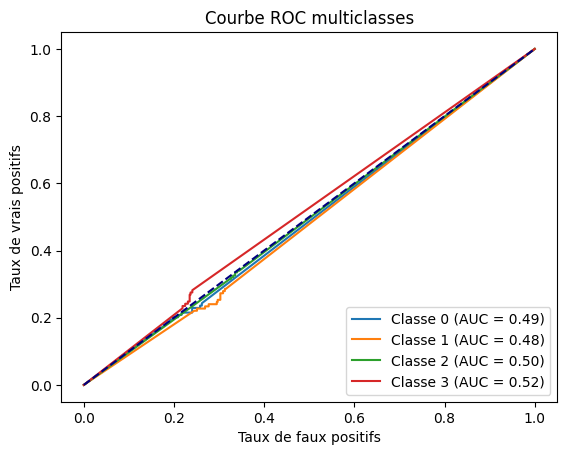

In [ ]:
# Tracer la courbe ROC
n_classes = true_classes_binarized.shape[1]

# Calcul des courbes ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracé des courbes ROC
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC multiclasses')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab_Notebooks/final_model_brain_tumor_detection.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>